In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/politics-on-reddit/reddit_politics.csv


In [2]:
df = pd.read_csv('/kaggle/input/politics-on-reddit/reddit_politics.csv')
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,https://www.vice.com/en/article/wx5bg5/blm-whi...,34,1.627710e+09,NaN,2021-07-31 08:35:47
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,https://www.kxan.com/news/texas-politics/doj-s...,17,1.627688e+09,NaN,2021-07-31 02:26:12
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,https://www.modbee.com/news/coronavirus/articl...,27,1.627671e+09,NaN,2021-07-30 21:45:09
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,https://www.orlandosentinel.com/politics/os-ne...,138,1.627660e+09,NaN,2021-07-30 18:43:05
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,https://www.tallahassee.com/story/news/politic...,28,1.627644e+09,NaN,2021-07-30 14:21:54


In [3]:
df.isnull().sum()

title            0
score            0
id               0
url          18027
comms_num        0
created          0
body          9995
timestamp        0
dtype: int64

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df.head()

,title,score,id,url,comms_num,created,body,timestamp,date
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,https://www.vice.com/en/article/wx5bg5/blm-whi...,34,1.627710e+09,NaN,2021-07-31 08:35:47,2021-07-31
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,https://www.kxan.com/news/texas-politics/doj-s...,17,1.627688e+09,NaN,2021-07-31 02:26:12,2021-07-31
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,https://www.modbee.com/news/coronavirus/articl...,27,1.627671e+09,NaN,2021-07-30 21:45:09,2021-07-30
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,https://www.orlandosentinel.com/politics/os-ne...,138,1.627660e+09,NaN,2021-07-30 18:43:05,2021-07-30
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,https://www.tallahassee.com/story/news/politic...,28,1.627644e+09,NaN,2021-07-30 14:21:54,2021-07-30


In [5]:
data = df[['date', 'title']]
data.head()

,date,title
0,2021-07-31,A Right Wing Group in Texas Is Making up Fake ...
1,2021-07-31,DOJ sues Texas over Gov. Abbott’s order for la...
2,2021-07-30,"From white evangelicals to QAnon believers, wh..."
3,2021-07-30,DeSantis says he’ll sign order allowing parent...
4,2021-07-30,"Show on the road: In Utah, Florida Gov. Ron De..."


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import re
import seaborn as sns
import matplotlib.pyplot as plt

def custom_tokenizer(text):
    # Define the word you want to exclude
    exclude_word = 'comment'
    # Use a regular expression to tokenize the text
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Exclude the specific word
    return [word for word in tokens if len(word) > 1 and word != exclude_word]

count_vectorizer  = CountVectorizer(stop_words = 'english',
                                    tokenizer=custom_tokenizer)

In [7]:
def top_n_words(top_n, count_vectorizer, data):
    vec_titles = count_vectorizer.fit_transform(data)
    vec_total = np.sum(vec_titles, axis = 0)
    word_indices = np.flip(np.argsort(vec_total)[0, :],1)
    word_values = np.flip(np.sort(vec_total)[0, :], 1)
    
    word_vectors = np.zeros((top_n, vec_titles.shape[1]))
    
    for i in range(top_n):
        word_vectors[i, word_indices[0,i]] = 1
    
    words = [word[0].encode('ascii').decode('utf-8') 
            for word in count_vectorizer.inverse_transform(word_vectors)]
    
    return (words, word_values[0, :top_n].tolist()[0])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


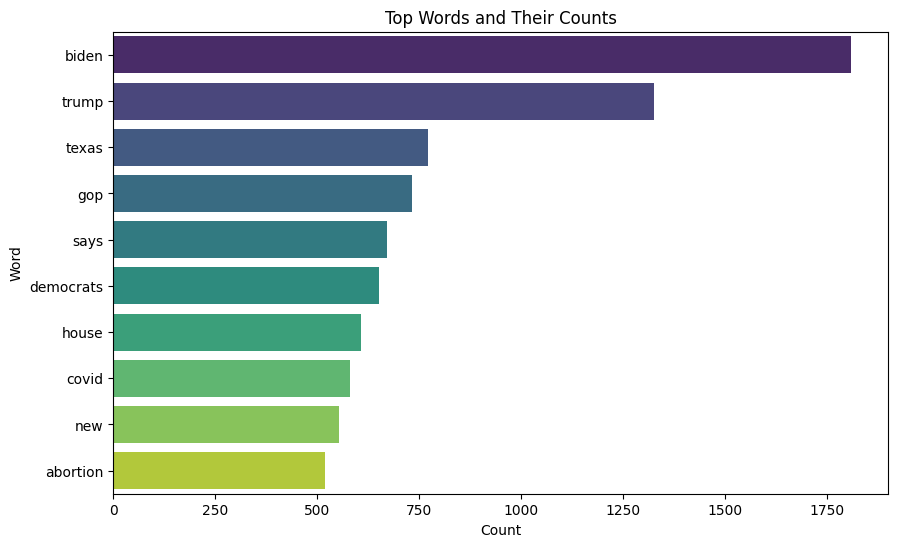

In [8]:
words, word_count = top_n_words(top_n = 10, count_vectorizer = count_vectorizer, data = data.title)
plt.figure(figsize=(10, 6))
sns.barplot(x=word_count, y=words, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top Words and Their Counts')
plt.show()



#### Text preprocessing for topic modelling

In [9]:
cnt_vec = CountVectorizer(stop_words = 'english', max_features = 40000)
text_sample = data['title'].sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(text_sample[152]))

small_document_term_matrix = cnt_vec.fit_transform(text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[152]))

Headline before vectorization: GOP Lawmaker Deletes Tweet Comparing Vaccine Mandates to the Holocaust
Headline after vectorization: 
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8 stored elements and shape (1, 6952)>
  Coords	Values
  (0, 3738)	1
  (0, 6603)	1
  (0, 2695)	1
  (0, 3498)	1
  (0, 1669)	1
  (0, 6446)	1
  (0, 1262)	1
  (0, 2946)	1


In [10]:
n_topics = 10

In [11]:
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [12]:
lsa_topic_matrix

array([[ 9.99999701e-01, -7.56925914e-05, -8.72526434e-05, ...,
        -3.05222390e-05,  5.03495291e-05,  7.60566821e-06],
       [ 9.99999701e-01, -7.56925914e-05, -8.72526434e-05, ...,
        -3.05222390e-05,  5.03495291e-05,  7.60566821e-06],
       [ 9.99999701e-01, -7.56925914e-05, -8.72526434e-05, ...,
        -3.05222390e-05,  5.03495291e-05,  7.60566821e-06],
       ...,
       [ 5.65560247e-06,  9.65040946e-01, -4.43073431e-01, ...,
        -5.60915960e-01,  1.97195018e-02, -7.36651222e-01],
       [ 9.99999701e-01, -7.56925914e-05, -8.72526434e-05, ...,
        -3.05222390e-05,  5.03495291e-05,  7.60566821e-06],
       [ 9.99999701e-01, -7.56925914e-05, -8.72526434e-05, ...,
        -3.05222390e-05,  5.03495291e-05,  7.60566821e-06]])